In [2]:
from osgeo import gdal, ogr, osr

In [4]:
InSR = osr.SpatialReference()
InSR.ImportFromEPSG(4326)  # 4326/Geographic
OutSR = osr.SpatialReference()
OutSR.ImportFromEPSG(3116)  # Colombia Bogota zone


coordTrans = osr.CoordinateTransformation(InSR, OutSR)
coordTrans.TransformPoint(-76.9907099666541, 6.781808049550044)

(677822.0009487688, 1242663.9609698448, 0.0)

### Shapefiles content

- .shp - shapefile - geometry
- .dbf - database - metadata
- .prj - projection
- .shx - index

link to learn QGIS: https://www.youtube.com/watch?v=PqX1hdzEJFE&list=PLjHRAtOKOOLhHyQHUXBCfSqOWHFJZ1Pnf&index=2

In [ ]:
!pip install geopandas;

In [ ]:
#Import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
import h5py    
import numpy as np
from shapely.geometry import shape
#from osgeo import osr, gdal, ogr
#gdal.UseExceptions()

In [ ]:
#Read dataset
path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Frontera_Agricola_Prueba/Frontera_Agricola_Prueba.shp'
#path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/Shapefile/prueba.shp'
#path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/Shapefile/geodata/ply_golfcourse-strasslach3857.shp'
path_to_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Intersection/Intersection.shp'
dataset = gpd.read_file(path_to_shp)

In [ ]:
#show dataset
dataset

,chip_name,labels,labels_num,geometry
0,"18NTN_8_5_(0, 0)",Bosques naturales y áreas no agropecuarias,0,"POLYGON ((677815.965 1241658.885, 677822.001 1..."
1,"18NTN_8_5_(0, 0)",Exclusiones legales,1,None
2,"18NTN_8_5_(0, 0)",Frontera agrícola nacional,2,"POLYGON ((678820.961 1241652.863, 678301.234 1..."


In [ ]:
#unique classes
#dataset.elemento.unique()

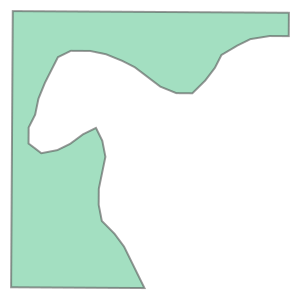

In [ ]:
dataset.iloc[0].geometry

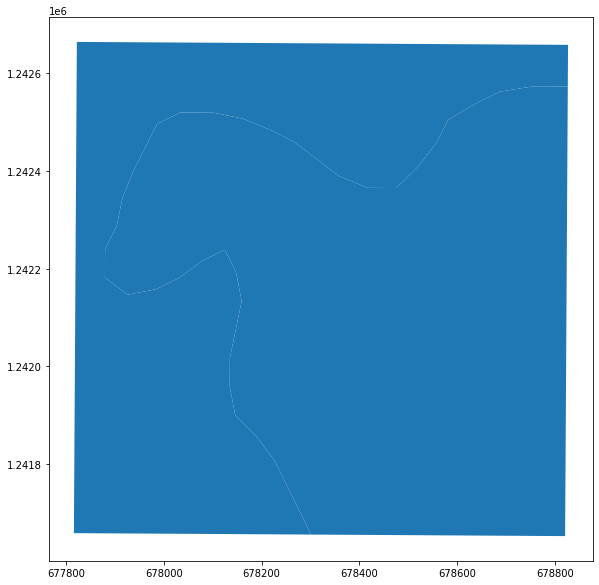

In [ ]:

dataset.plot(figsize=(15,10))

In [ ]:
#projection
dataset.crs

<Projected CRS: EPSG:3116>
Name: MAGNA-SIRGAS / Colombia Bogota zone
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia MAGNA Bogota zone
- method: Transverse Mercator
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
dataset.to_crs('epsg:4326', inplace=True)

In [ ]:
dataset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Conver shipefile to raster Geotiff using GDLA and osgeo library

In [ ]:
def shapefiel_to_geotiff(path_input_shp, path_output_raster, pixel_size, attribute, no_data_value=-999):


    """
    This function allow you to convert a shapefile in a Geotiff. In order to use this function
    shapefile projection must be in Cartesian system in meters.

    Arguments:
        path_input_shp: string.
            path where the shapefile is located.
        path_output_raster: string.
            path to save the output raster
        pixel_size: float.
            size of he pixel in the output raster
        attribute: string.
            attribute to burn pixel values.
        no_data_value: int (default=-999).
            integer for no data values              

    """
    
    #create the input Shapefile object, get the layer information, and finally set the extent values
    open_shp = ogr.Open(path_input_shp)
    shp_layer = open_shp.GetLayer()
    x_min, x_max, y_min, y_max = shp_layer.GetExtent()


    #calculate the resolution distance to pixel value:
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)
    print((x_max - x_min) / pixel_size)

    #image type
    image_type = 'GTiff'

    #Our new raster type is a GeoTiff, so we must explicitly tell GDAL to get this driver.
    #The driver is then able to create a new GeoTiff by passing in the filename or the
    #new raster that we want to create, called the x direction resolution, followed by the y
    #direction resolution, and then the number of bands; in this case, it is 1. Lastly, we set
    #a new type of GDT_Byte raster:
    driver = gdal.GetDriverByName(image_type)
    new_raster = driver.Create(path_output_raster, x_res, y_res, 1, gdal.GDT_Int16)
    new_raster.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    #new_raster.SetProjection(shp_layer.GetSpatialRef().ExportToWkt())


    #Now we can access the new raster band and assign the no data values and the inner
    #data values for the new raster. All the inner values will receive a value of 255 similar
    #to what we set in the burn_values variable:


    # get the raster band we want to export too
    raster_band = new_raster.GetRasterBand(1)

    # assign the no data value to empty cells
    raster_band.SetNoDataValue(no_data_value)

    # run vector to raster on new raster with input Shapefile
    gdal.RasterizeLayer(new_raster, [1], shp_layer, options = [f"ATTRIBUTE={attribute}"])

    #burn value
    #gdal.RasterizeLayer(new_raster, [1], shp_layer, burn_values=[255])

Import the libraries ogr and gdal, and then define our output pixel size along with a
value to assign to null:

In [ ]:
#Import libraries
from osgeo import osr, gdal, ogr

In [ ]:
# set pixel size
pixel_size = 10
no_data_value = 0

Set up the input Shapefile we want to convert alongside the new GeoTiff raster that
will be created when the script is executed:

In [ ]:
#input_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/Shapefile/prueba.shp'
input_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Frontera_Agricola_Prueba/Frontera_Agricola_Prueba.shp'
output_raster = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/prueba.tif'
input_shp = '/content/drive/MyDrive/Colab Notebooks/Maestria Ing/Theses/GeoDataset/Intersection/Intersection.shp'

In [ ]:
##converrt shapefile to geotif
shapefiel_to_geotiff(input_shp, output_raster, pixel_size, no_data_value = 3, attribute = 'labels_num')

1011.0129706495209


## visualize Geotiff Image

In [ ]:
#open geotiff image
raster_image = gdal.Open(output_raster).ReadAsArray()
raster_image.shape

(1011, 1011)

In [ ]:
np.unique(raster_image)

array([0, 2, 3], dtype=int16)

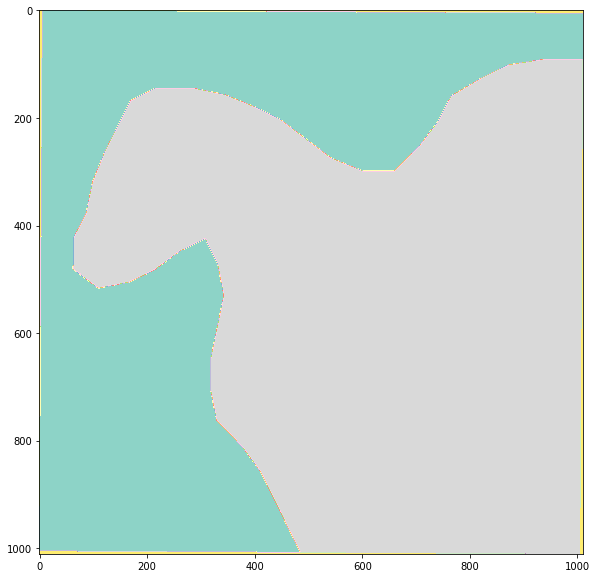

In [ ]:
#plotbinary mask
plt.figure(figsize=(25,10))
plt.imshow(raster_image, cmap='Set3')

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
from rasterio.plot import show
img = rasterio.open(output_raster)

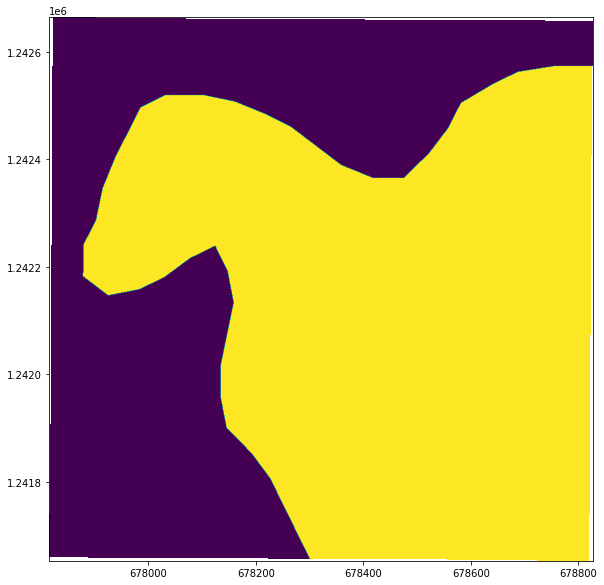

In [ ]:
plt.figure(figsize=(25,10))
show(img)